In [120]:
import tweepy       # python wrapper for twitter api
import json
import time
import requests
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer
import matplotlib.pyplot as plt

%matplotlib inline

# step 0, get your own twitter credentials!

In [ ]:
# this is my own personal twitter api information
# if you could be so kind as to sign up yourself on both twitter and mashape that'd be great :)
# It's FREEEEEEE
api_key = 'g3xAZVinye67J9guxFhGT5Y8f'
api_secret = 'TYkqHGyBxNSoziaap8LtygafZpD6cHjLuiIdgfbvNRr3RV2fwU'
access_token = '536799553-4jpBdlg8XMtnXCVEA2daxrDYuwT4HTQNx7eEOtoJ'
access_secret = 'Mya4FnubounjlXM1Vh4fwDTLwOjIT6UbTNiBzQQUEAJqI'

In [ ]:
# Documentation is your friend! http://docs.tweepy.org/en/v3.1.0/
auth = tweepy.OAuthHandler(api_key, api_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth) # returns a tweepy authorization handler object

In [ ]:
# 1. Use Twitter API to stream and store tweets (300 per candidate)
# explain geocode is doing
bernie_tweets =  api.search(q="#berniesanders", count=100, geocode="37.781157,-122.398720,50mi") + api.search(q='#bernie', count=100, geocode="37.781157,-122.398720,50mi") + api.search(q='#FeelTheBern', count=100, geocode="37.781157,-122.398720,50mi")
hilary_tweets = api.search(q='#ImWithHer', count=100, geocode="37.781157,-122.398720,50mi") + api.search(q='#hillaryclinton', count=100, geocode="37.781157,-122.398720,50mi") + api.search(q='#hillary2016', count=100, geocode="37.781157,-122.398720,50mi")
the_donald_tweets = api.search(q='#donaldtrump', count=100, geocode="37.781157,-122.398720,50mi") + api.search(q='#trump2016', count=100, geocode="37.781157,-122.398720,50mi") + api.search(q='#trump', count=100, geocode="37.781157,-122.398720,50mi") + api.search(q='#makeamericagreatagain', count=100, geocode="37.781157,-122.398720,50mi")

Geocode is returning only tweets from within 50 miles of the given coordinates

In [ ]:
the_donald_tweets[0]

In [ ]:
# wrappers come with built in python attributes and methods!
print dir(the_donald_tweets[0])

In [ ]:
print the_donald_tweets[0].created_at
print the_donald_tweets[0].text
print the_donald_tweets[0].favorite_count
print the_donald_tweets[0].favorited
print the_donald_tweets[0].lang
print the_donald_tweets[0].geo
print the_donald_tweets[0].retweet_count
print the_donald_tweets[0].retweeted
print the_donald_tweets[0].coordinates

In [ ]:
def parse_status_objects(tweet_list,candidate, party):
    modified_tweets = list()
    for x in tweet_list:
        modified_tweets.append( [
                    x.created_at,
                    x.text,
                    x.favorite_count,
                    x.favorited,
                    x.lang,
                    x.geo,
                    x.retweet_count,
                    x.retweeted,
                    x.coordinates,
                    candidate,
                    party
                ])
    return modified_tweets
        
hilary_tweets = parse_status_objects(hilary_tweets,0,1)
the_donald_tweets = parse_status_objects(the_donald_tweets,2,0)
bernie_tweets = parse_status_objects(bernie_tweets,1,1)

In [ ]:
print bernie_tweets[0]
print the_donald_tweets[0]
print hilary_tweets[0]

In [266]:
# 2 Create a dataframe that combines all of the tweets from each candidate
# To do so, you will need to concat the data frames
# so each row is a tweet and your columns should be 
# date, text, favorite_count,favorited, language, geocode, rwtweet count, retweeted, coordinates

'''Bernie = pd.DataFrame(data = bernie_tweets, columns = ['date', 'text', 'favorite_count', 'favorited', 'language', 
                                                       'geocode', 'rwtweet count', 'retweeted', 'coordinates','candidate','party'])

Donald = pd.DataFrame(data = the_donald_tweets, columns = ['date', 'text', 'favorite_count', 'favorited', 'language', 
                                                       'geocode', 'rwtweet count', 'retweeted', 'coordinates','candidate','party'])

Hilary = pd.DataFrame(data = hilary_tweets, columns = ['date', 'text', 'favorite_count', 'favorited', 'language', 
                                                       'geocode', 'rwtweet count', 'retweeted', 'coordinates','candidate','party'])'''

Combined_tweets = bernie_tweets + hilary_tweets + the_donald_tweets

df = pd.DataFrame(data = Combined_tweets, columns = ['date', 'text', 'favorite_count', 'favorited', 'language', 
                                                       'geocode', 'rwtweet count', 'retweeted', 'coordinates','pres_candidate','polit_party'])
pd.set_option('max_colwidth', 500)



In [267]:
df.polit_party.value_counts()

1    579
0    400
Name: polit_party, dtype: int64

In [268]:
# 3 Create a function to take in a string and output the textblob sentiment of that string
def sentiment(string):
    tweet = TextBlob(string)
    return tweet.sentiment.polarity

In [269]:
# 4 Add a column to your data frame called 'sentiment' which holds the sentiment of that tweet (hint: use the function from #3)
df['sentiment'] = df.text.apply(sentiment)

In [275]:
df.iloc[0]

date                                               2016-05-12 00:20:44
text              #BernieSanders #Election2016 https://t.co/Wauk1SXvN2
favorite_count                                                       0
favorited                                                        False
language                                                           und
geocode                                                           None
rwtweet count                                                        0
retweeted                                                        False
coordinates                                                       None
pres_candidate                                                       1
polit_party                                                          1
sentiment                                                            0
Name: 0, dtype: object

In [277]:
# 5 create a word count column, which holds the number of words in the text column
def wordcount(string):
    tweet = TextBlob(string)
    return len(tweet.words)

df['word_count'] = df.text.apply(wordcount)


for x in df.favorite_count:
    if df.favorite_count[x] > 0:
        df.favorited[x] = True
    
for x in df['rwtweet count']:
    if df['rwtweet count'][x] > 0:
        df.retweeted[x] = True
        
df.sentiment.value_counts()

/Users/Vicky/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Vicky/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


 0.000000    473
-0.300000     71
-0.250000     32
 0.500000     28
 0.100000     22
 0.125000     19
 0.250000     18
-0.400000     18
-0.500000     18
 0.200000     14
 0.625000     13
 0.600000     12
 1.000000     12
 0.136364      9
 0.300000      9
-0.200000      9
 0.050000      9
-0.600000      8
 0.400000      8
 0.800000      7
-0.200000      6
-0.033333      6
 0.212500      6
 0.364286      6
-0.100000      5
 0.366667      4
-0.312500      4
-0.300000      3
 0.700000      3
 0.266667      3
            ... 
 0.490625      1
 0.260000      1
-0.520833      1
 0.141667      1
-0.122159      1
 0.350000      1
-0.083333      1
-0.191667      1
 0.166667      1
 0.425000      1
 0.560417      1
-0.450000      1
 0.300606      1
 0.525000      1
-0.700000      1
 0.066667      1
 0.033333      1
 0.288889      1
-0.900000      1
 0.650000      1
 0.272222      1
 0.155000      1
 0.433333      1
 0.160000      1
-0.333333      1
 0.208333      1
 0.283333      1
 0.050000     

Note that most of the sentiments (473 out of 979 are neutral) and that this can potentially skew the data

In [211]:
# use countvectorizer to create a document-term matrix and concatinate it to your main dataframe
#(hint you should now have thousands of columns)

vect = CountVectorizer(ngram_range = (1,2), stop_words='english', min_df =2)
doc_matrix = pd.DataFrame(vect.fit_transform(df.text).toarray(), columns=vect.get_feature_names())
type(df)


pandas.core.frame.DataFrame

In [212]:
print doc_matrix.index
print df.index
len(df.index)

RangeIndex(start=0, stop=979, step=1)
RangeIndex(start=0, stop=979, step=1)


979

In [222]:
pres_tweets = pd.concat([df, doc_matrix], axis=1)
pres_tweets.head()


,date,text,favorite_count,favorited,language,geocode,rwtweet count,retweeted,coordinates,pres_candidate,...,yrs,yuge,yuge margin,z4zixevjhk,zesty_entrepren,zesty_entrepren donaldtrump,zesty_facebook,zesty_facebook facebook,zxkbzerzvo,zxkbzerzvo voting
0,2016-05-12 00:20:44,#BernieSanders #Election2016 https://t.co/Wauk1SXvN2,0,False,und,None,0,False,None,1,...,0,0,0,0,0,0,0,0,0,0
1,2016-05-12 00:01:55,For anyone wanting to know when and where the next rally is happening! #KeepingTrack #GoBernie! #BernieSanders... https://t.co/PxWkthjvu4,0,False,en,None,0,False,None,1,...,0,0,0,0,0,0,0,0,0,0
2,2016-05-11 22:37:15,#Election2016 #HillaryClinton #BernieSanders https://t.co/2bAERw9WUB,0,False,und,None,0,False,None,1,...,0,0,0,0,0,0,0,0,0,0
3,2016-05-11 22:27:32,Come on! Switch to Democrat or undeclared if you wanna vote Bernie! #BernieSanders #BayArea #Election2016 #Vote!... https://t.co/jB7RRHVMJi,0,False,en,None,0,False,None,1,...,0,0,0,0,0,0,0,0,0,0
4,2016-05-11 21:38:51,The attack on #BernieSanders’ single-payer plan is 'ridiculous' #UniversalHealthCare https://t.co/Bnev15UbLx,2,True,en,None,0,False,None,1,...,0,0,0,0,0,0,0,0,0,0


In [223]:
X_clusters.shape

(979, 2696)

In [224]:
# 6 Use kmean to create clusters for the dataframe
X_clusters = pres_tweets.drop(['date','text','pres_candidate', 'polit_party', 'language', 'geocode', 'coordinates'], axis =1)
                               
from sklearn.cluster import KMeans
km = KMeans(n_clusters=4, random_state=1)
km.fit(X_clusters)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=4, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [225]:
pres_tweets.polit_party.value_counts()

1    579
0    400
Name: polit_party, dtype: int64

In [226]:
pres_tweets['cluster'] = km.labels_
pres_tweets.sort('cluster')


/Users/Vicky/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,date,text,favorite_count,favorited,language,geocode,rwtweet count,retweeted,coordinates,pres_candidate,...,yuge,yuge margin,z4zixevjhk,zesty_entrepren,zesty_entrepren donaldtrump,zesty_facebook,zesty_facebook facebook,zxkbzerzvo,zxkbzerzvo voting,cluster
337,2016-05-11 18:49:03,"RT @JenGranholm: .@realDonaldTrump, tired of dividing citizens from immigrants, Mexicans, Muslims -now dividing men and women. We need a un…",0,False,en,None,22,False,None,0,...,0,0,0,0,0,0,0,0,0,0
835,2016-05-11 22:07:22,RT @JacloPac: Lying #Ryan is no different than #Trump we can't believe anything either one says. Never Vote #Republican https://t.co/ORuZMv…,0,False,en,None,33,False,None,2,...,0,0,0,0,0,0,0,0,0,0
180,2016-05-12 00:33:19,RT @oaklandbern: Call voters for #OregonPrimary NOW! Join #TeamSecondWave and be a part of the REVOLUTION! #FeelTheBern https://t.co/HRzvRG…,0,False,en,None,27,True,None,1,...,0,0,0,0,0,0,0,0,0,0
840,2016-05-11 21:56:37,RT @JacloPac: Lying #Ryan is no different than #Trump we can't believe anything either one says. Never Vote #Republican https://t.co/ORuZMv…,0,False,en,None,33,False,None,2,...,0,0,0,0,0,0,0,0,0,0
842,2016-05-11 21:45:49,RT @JacloPac: Lying #Ryan is no different than #Trump we can't believe anything either one says. Never Vote #Republican https://t.co/ORuZMv…,0,False,en,None,33,False,None,2,...,0,0,0,0,0,0,0,0,0,0
843,2016-05-11 21:44:41,"RT @JacloPac: Elizabeth Warren: “#Trump has built his campaign on racism, sexism &amp; xenophobia,” he's a lame, weak, bully &amp; loser! https://t…",0,False,en,None,95,False,None,2,...,0,0,0,0,0,0,0,0,0,0
844,2016-05-11 21:44:27,RT @JacloPac: Lying #Ryan is no different than #Trump we can't believe anything either one says. Never Vote #Republican https://t.co/ORuZMv…,0,False,en,None,33,False,None,2,...,0,0,0,0,0,0,0,0,0,0
185,2016-05-12 00:07:41,RT @oaklandbern: Call voters for #OregonPrimary NOW! Join #TeamSecondWave and be a part of the REVOLUTION! #FeelTheBern https://t.co/HRzvRG…,0,False,en,None,27,False,None,1,...,0,0,0,0,0,0,0,0,0,0
845,2016-05-11 21:43:24,"RT @ScottAdamsSays: ""Crazy Bernie"" is the yellow sticky note of linguistic kill shots. It sticks for now, but comes off easily. Perfectly d…",0,False,en,None,74,False,None,2,...,0,0,0,0,0,0,0,0,0,0
847,2016-05-11 21:42:55,RT @JacloPac: #Trump's already begun building his wall. #NeverTrump https://t.co/AbzUiXcCJF,0,False,en,None,42,False,None,2,...,0,0,0,0,0,0,0,0,0,0


In [227]:
#calculate the Silhouette Coefficient
from sklearn import metrics
metrics.silhouette_score(X_clusters, km.labels_)

0.67051062509314419

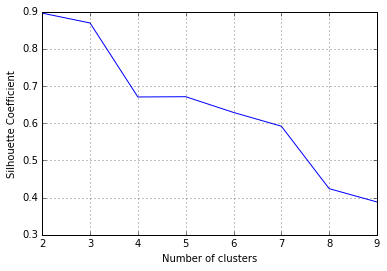

In [219]:
#tune the parameters
k_range = range(2, 10)
scores = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(X_clusters)
    scores.append(metrics.silhouette_score(X_clusters, km.labels_))
    
# plot the results
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.grid(True)

In [165]:
# K-means with # clusters on scaled data
#km = KMeans(n_clusters=5, random_state=1)
#km.fit(X_clusters)
#metrics.silhouette_score(X_clusters, km.labels_)


0.66917768545476675

In [166]:
# 7 Explore the clusters
# What is interesting? Surprising? Can you draw any inferences about each cluster?
# Write your answer to these questions in markdown

In [228]:
centers = pres_tweets.groupby('cluster').mean()
centers

,favorite_count,favorited,rwtweet count,retweeted,pres_candidate,polit_party,sentiment,word_count,000,000 000,...,yrs,yuge,yuge margin,z4zixevjhk,zesty_entrepren,zesty_entrepren donaldtrump,zesty_facebook,zesty_facebook facebook,zxkbzerzvo,zxkbzerzvo voting
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.104167,0.000000,37.666667,0.055556,1.131944,0.673611,-0.085431,18.479167,0.750000,0.5625,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,489.166667,0.041667,0.250000,0.958333,0.058333,15.333333,0.000000,0.0000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,156.402062,0.000000,1.577320,0.237113,-0.217290,20.505155,0.000000,0.0000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.693277,0.004202,3.287115,0.032213,1.060224,0.610644,0.082535,16.025210,0.002801,0.0000,...,0.004202,0.004202,0.004202,0.002801,0.002801,0.002801,0.004202,0.004202,0.008403,0.008403


In [ ]:
import numpy as np
colors = np.array(['red', 'green', 'blue', 'yellow', 'purple'])

pd.scatter_matrix(X_clusters, c= colors[list(pres_tweets.cluster)], figsize=(10,10), s=100)

In [ ]:
# 8 Create a column called 'democrat' and assign it to the corresponding candidate name for all the records
# 1 for bernie and hilary and 0 for donald trump

In [ ]:
# 9 Estimate classification models using knn and logistic regession.  Dont forget to use cross validation 
    # (do not use cross_val_score because we will want a confusion matrix).
# Use a three class response variable for knn.  For logistic regression predict democrat or republic?
#Assess the pros and cons of both approaches
#Extra Credit: Estimate multinomial regression model using the three class response variable

In [231]:
X_clusters = pres_tweets.drop(['date','text','pres_candidate', 'polit_party', 'language', 'geocode', 'coordinates', 'cluster'], axis =1)

In [232]:
# split into training and testing sets
from sklearn.cross_validation import train_test_split
lgX_train, lgX_test, lgy_train, lgy_test = train_test_split(X_clusters, pres_tweets.polit_party, random_state=1)

knnX_train, knnX_test, knny_train, knny_test = train_test_split(X_clusters, pres_tweets.pres_candidate, random_state=1)

In [239]:
pres_tweets.polit_party.value_counts()

1    579
0    400
Name: polit_party, dtype: int64

In [233]:
# 10 Initialize a classification model (for both knn and logistic)

In [234]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

In [235]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)

In [236]:
# 11 Train your classification model  (for both knn and logistic)

In [237]:
logreg.fit(lgX_train, lgy_train)
logreg.score(lgX_train, lgy_train)

0.9877384196185286

0.96457765667574935

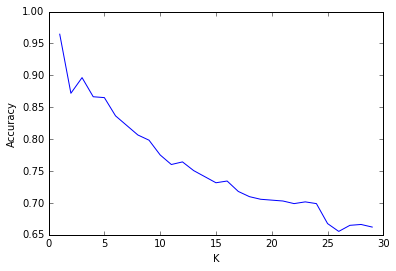

In [238]:
knn.fit(knnX_train, knny_train)

scores = []
for i in range(1, 30):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(knnX_train, knny_train)
    scores.append(knn.score(knnX_train, knny_train))
    
plt.plot(range(1,30), scores)
plt.ylabel("Accuracy")
plt.xlabel("K")

max(scores)

In [179]:
# 12 Predict on your test features and targets (for both knn and logistic)

In [240]:
lgpreds = logreg.predict(lgX_test)

In [241]:
knnpreds = knn.predict(knnX_test)

In [242]:
# 13 output your accuracy (for both knn and logistic)

In [254]:
from sklearn import metrics
print metrics.accuracy_score(lgy_test, lgpreds)

logreg.coef_

0.967346938776


array([[ 0.00037641,  0.08226047,  0.00216625, ...,  0.05251643,
        -0.05092909, -0.05092909]])

In [250]:
# compare to null accuracy rate
lgy_test.value_counts()

1    150
0     95
Name: polit_party, dtype: int64

In [253]:
null_accuracy = 150.0/(150+95)
null_accuracy

0.6122448979591837

In [245]:
lgy_test.value_counts()

1    150
0     95
Name: polit_party, dtype: int64

In [246]:
print metrics.accuracy_score(knny_test, knnpreds)

0.648979591837


In [247]:
# 14 Create a confusion matrix for your predictions (for both knn and logistic)

In [248]:
from nltk import ConfusionMatrix
print ConfusionMatrix(list(lgy_test), list(lgpreds))

  |   0   1 |
--+---------+
0 | <92>  3 |
1 |   5<145>|
--+---------+
(row = reference; col = test)



In [249]:
print ConfusionMatrix(list(knny_test), list(knnpreds))

  |  0  1  2 |
--+----------+
0 |<38>14 25 |
1 | 11<49>13 |
2 | 14  9<72>|
--+----------+
(row = reference; col = test)



In [264]:
# 15 Who is the easiest candidate to predict? Why do you think? Who is the hardest? Why do you think?
# Write your answers in markdown (for both knn and logistic)

lgy_test[lgy_test != lgpreds]

zip(lgy_test, lgpreds)

[(0, 0),
 (0, 0),
 (0, 0),
 (1, 1),
 (0, 0),
 (1, 1),
 (0, 0),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (0, 0),
 (1, 1),
 (1, 1),
 (1, 1),
 (0, 0),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (0, 0),
 (1, 1),
 (1, 1),
 (1, 1),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (1, 1),
 (1, 0),
 (1, 1),
 (0, 0),
 (0, 0),
 (1, 1),
 (1, 1),
 (0, 0),
 (0, 0),
 (1, 1),
 (1, 1),
 (0, 0),
 (1, 1),
 (0, 0),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (0, 0),
 (1, 1),
 (0, 0),
 (1, 1),
 (0, 0),
 (0, 0),
 (1, 1),
 (0, 0),
 (0, 0),
 (1, 1),
 (0, 0),
 (1, 1),
 (0, 0),
 (0, 0),
 (1, 1),
 (0, 0),
 (1, 1),
 (0, 0),
 (0, 0),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (0, 0),
 (0, 0),
 (1, 1),
 (1, 1),
 (0, 1),
 (1, 1),
 (1, 1),
 (0, 0),
 (1, 1),
 (1, 0),
 (1, 1),
 (0, 0),
 (1, 1),
 (0, 0),
 (0, 0),
 (1, 1),
 (0, 0),
 (1, 1),
 (1, 1),
 (0, 0),
 (0, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (0, 0),
 (0, 0),
 (1, 1),
 (1, 1),
 (0, 0),
 (0, 0),
 (1, 1),
 (0, 0),
 (0, 0),
 (0, 0),
 (1, 1),
 (1, 1),
 

In [ ]:
# 16 What are some extra features (data points) you would like to add to this data set. Explain in markdown.
# (hint maybe something like a boolean, "has_hashtag")

In [ ]:
# 17 Try adding extra features to improve the quality of your predictions (for both knn and logistic)